In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

2022-08-09 21:21:04.430429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 21:21:04.430462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#Size of our input images
SIZE = 128
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = datagen.flow_from_directory(
    "../../data/chest_xray/train/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode="input"
    )

validation_generator = datagen.flow_from_directory(
    '../../data/chest_xray/test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )
anomaly_generator = datagen.flow_from_directory(
    '../../data/chest_xray/PN_test_copy/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 1341 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.


In [6]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

2022-08-09 21:22:31.002025: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-09 21:22:31.002055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-09 21:22:31.002342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/20
7/7 [==============================] - 13s 2s/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 2/20
7/7 [==============================] - 11s 1s/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 3/20
7/7 [==============================] - 11s 1s/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 4/20
7/7 [==============================] - 11s 1s/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 5/20
7/7 [==============================] - 11s 1s/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 6/20
7/7 [==============================] - 11s 1s/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 7/20
7/7 [==============================] - 11s 1s/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 8/20
7/7 [==============================] - 11s 1s/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0

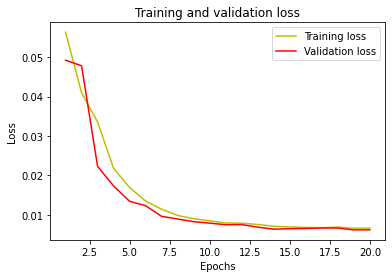

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

In [10]:
predicted = model.predict(data_batch[0])  #Predict on the first batch of images

2/2 [==============================] - 0s 68ms/step


In [63]:
data_batch[0].shape

(64, 128, 128, 3)

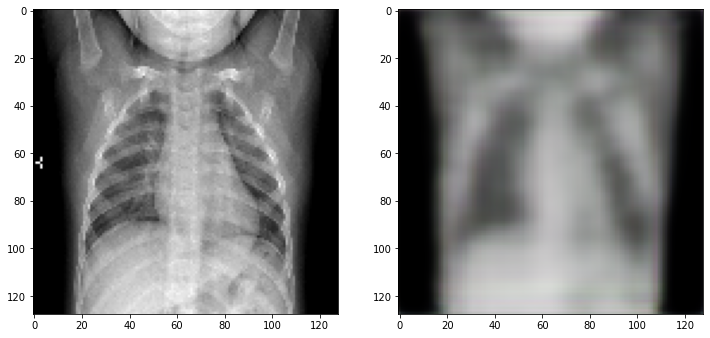

In [13]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [14]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

7/7 [==============================] - 1s 177ms/step - loss: 0.0048 - mse: 0.0048
Recon. error for the validation (normal) data is:  [0.006124778650701046, 0.006124778650701046]
Recon. error for the anomaly data is:  [0.004817017819732428, 0.004817017819732428]


In [15]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [16]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

21/21 [==============================] - 16s 741ms/step


In [17]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [18]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 20ms/step - loss: 0.0051 - mse: 0.0051


In [76]:
len(uninfected_values), len(anomaly_values)

(4, 4)

In [101]:
img = anomaly_batch[0]
img = img[np.newaxis, :,:,:]
type(img), img.shape

(numpy.ndarray, (1, 128, 128, 3))

In [119]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2680 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.0075 # Set this value based on the above exercise
    # img  = batch_images[0]
    # img = img[np.newaxis, :,:,:]
    img  = Image.open(img_path)
    img = img.resize((128, 128))
    #img = np.array(img.resize((128,128), Image.LANCZOS))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    #img = img[np.newaxis, :,:]
    #img = img[:,:]
    # # img = img.resize((128, 128))
    # # img_array = img_to_array(img).astype('float32')
    # # img_array = np.expand_dims(img_array, axis=0)
    # # img_array = img_array/255.0
    # #plt.imshow(img)
    # img = img / 255.
    #return type(img), img.shape
    
    encoded_img = encoder_model.predict([[img]]) 

    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

In [48]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('../../data/chest_xray/PN_test_copy/PNEUMONIA/*')
uninfected_file_paths = glob.glob('../../data/chest_xray/train/NORMAL/*')

In [64]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_anomaly_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= anomaly_generator.batch_index:   #gets each generated batch of size batch_size
    data = anomaly_generator.next()
    data_anomaly_batch.append(data[0])
    img_num = img_num + 1

In [120]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

2022-08-09 22:40:05.355540: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops_fused_impl.h:679 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 1 vs 3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/conv2d_7/Relu' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_715061/1162245215.py", line 3, in <cell line: 3>
      check_anomaly(para_file_paths[num])
    File "/tmp/ipykernel_715061/2227525935.py", line 10, in check_anomaly
      encoded_img = encoder_model.predict([[img]])
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 278, in call
      return self.activation(outputs)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "/home/iotg/work/SWA/SWA/kn_venv/lib/python3.8/site-packages/keras/backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_7/Relu'
input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node sequential_1/conv2d_7/Relu}}]] [Op:__inference_predict_function_27264]

/tmp/ipykernel_715061/4037329603.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

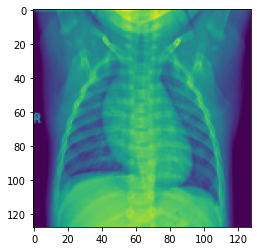

In [31]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])